In [3]:
from scipy.optimize import minimize, brute
from blender_tissue_cartography import rotation as tcrot
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import harmonic as tcharm
from spherical_analysis import * 
from skimage import io, exposure, transform
import json
import os

In this notebook, we give an example of generating the pullback using the lambert-azimuthal projection.

First, we rotate the embryo into a common reference frame.

In [5]:
# paremters
json_dir = r"/mnt/data1/Code/GH_local/spherical_harmonic_rotation/dataset_8/"
json_name = r"dataset_8.json"

# reads in json 
with open(os.path.join(json_dir, json_name), 'r') as f:
    dataset = json.load(f)

# sort by time if not already
dataset = dict(sorted(dataset.items(), key=lambda x: int(x[0][4:])))

# convert back necessary values back to nd_array
for d in dataset.values():
    d['center'] = np.array(d['center'])

Register to this "upright-arrow".

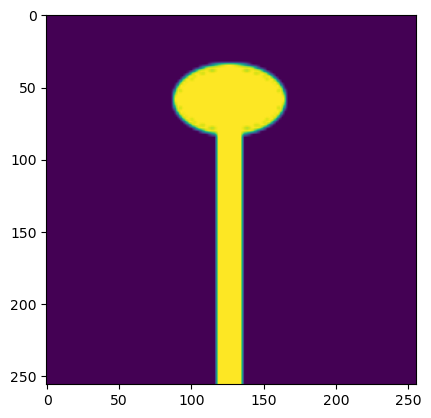

In [6]:
# load in a registration template
template = transform.resize(io.imread("Circular-Arrow.tif"), (256, 256))
plt.imshow(template)

In [7]:
uv_grid_steps = 256

# integration grid
phi_grid, theta_grid = np.meshgrid(np.arange(uv_grid_steps), np.arange(uv_grid_steps))
phi_grid = 2*np.pi*phi_grid/uv_grid_steps
theta_grid = np.pi*theta_grid/uv_grid_steps

# create measure
dTheta, dPhi = (np.pi/uv_grid_steps, 2*np.pi/uv_grid_steps)
weights = np.sin(theta_grid)*dTheta*dPhi # spherical integration measure

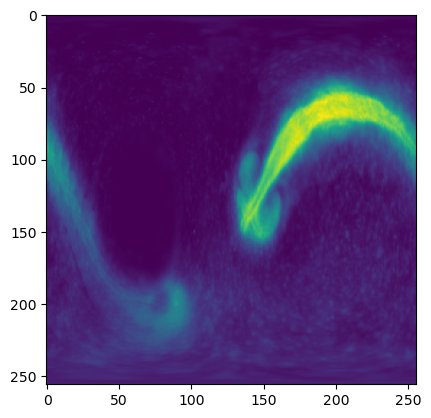

In [8]:
# select time point with well defined features
d = dataset['time95']

# read in image 
im = clip_pad_image(io.imread(d['path']), d['alpha'], d['padding'])

# create pullback
im_vol = create_interpolated_volume(im)
f = np.sum(spherical_pullback(im_vol, d['center'], d['radius'], thickness=64, theta_res=256, phi_res=256), axis=0)

# view 
plt.imshow(f)

In [9]:
# compute coefficients
coeffs_im = tcrot.compute_spherical_harmonics_coeffs(f, phi_grid, theta_grid, weights=weights, max_l=8)
coeffs_template = tcrot.compute_spherical_harmonics_coeffs(template, phi_grid, theta_grid, weights=weights, max_l=8)

# get rotation
rotation_inferred, overlap = tcrot.rotational_alignment(coeffs_im, coeffs_template, allow_flip=False, n_subdiv_axes=2, n_angle=200, maxfev=500)

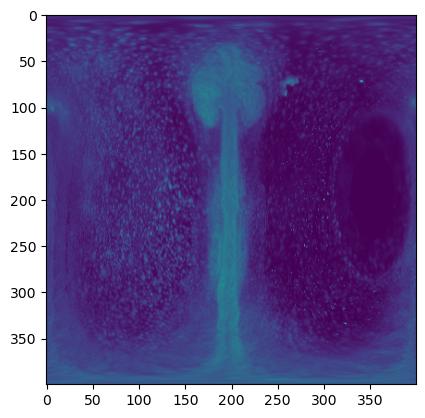

In [10]:
# create the pullback in with the rotation
im_vol_rotated = create_rotated_volume(im_vol, rotation_inferred.T, d['center']) 

# change the resolution, use a max projection instead of sum projection for aesthetics
f_rot = np.max(spherical_pullback(im_vol_rotated, d['center'], d['radius'], thickness=64, theta_res=400, phi_res=400), axis=0)

plt.imshow(f_rot)

Now, we want to perform a lambert azimuthal equal area projection.

In [12]:
def create_interpolated_area(im):
    """Interpolate an image. Takes inputs in ranges [0, pi] x [0, 2*pi]"""
    x_max, y_max = im.shape
    x_pts = np.linspace(0, np.pi, x_max)
    y_pts = np.linspace(0, 2*np.pi, y_max)
    return interp.RegularGridInterpolator((x_pts, y_pts), im, bounds_error=False, fill_value=0)

def lambert_equidistant_plane_polar_to_spherical(R, Theta):
    """Takes in R, Theta in [0, 2] x [0, 2pi] and gives you back spherical coordinates
    r, theta in [pi, 2pi] x [0, 2pi]"""
    return 2*np.arccos(R/2) , Theta + np.pi

def cartesian_to_plane_polar(x, y):
    """Takes in x, y in [-2, 2] x [-2, 2] to plane polar with r, theta in [0, 2] x [0, 2pi]."""
    return np.sqrt(x**2 + y**2), np.arctan2(y, x)

def create_interpolated_area_lambert_equidistant_projection(f_theta_phi):
    """Turns f(theta, phi) on a sphere to f(R, Theta) on a disc [0, 2] x [0, 2pi]."""

    def f_R_Theta(R, Theta):
        return f_theta_phi(lambert_equidistant_plane_polar_to_spherical(R, Theta))
    
    return f_R_Theta

def lambert_equidistant_projection(f_theta_phi, x_res=128, y_res=128):
    """Gets the lambert equidistant projection of a function that is defined on a sphere, 
    creating a mapping from f(theta, phi) to f(R(x, y), Theta(x, y)). 
    See https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection for more details."""
    # x_pts = np.linspace(2, -2, x_res)
    # y_pts = np.linspace(2, -2, y_res)
    x_pts = np.linspace(-2, 2, x_res)
    y_pts = np.linspace(-2, 2, y_res)
    x_grid, y_grid = np.meshgrid(x_pts, y_pts, indexing='ij')
    
    f_R_Theta = create_interpolated_area_lambert_equidistant_projection(f_theta_phi)

    R_grid, Theta_grid = cartesian_to_plane_polar(x_grid, y_grid)
    sampled = f_R_Theta(R_grid, Theta_grid)
    embedding = (R_grid, Theta_grid)
    return sampled, embedding

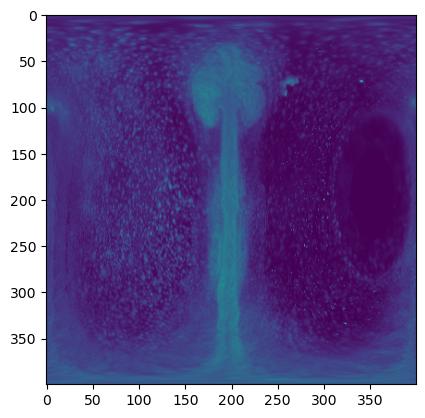

In [13]:
f_theta_phi = create_interpolated_area(f_rot)
x_max, y_max = f_rot.shape
x_pts = np.linspace(0, np.pi, x_max)
y_pts = np.linspace(0, 2*np.pi, y_max)
x_grid, y_grid = np.meshgrid(x_pts, y_pts, indexing='ij')
plt.imshow(f_theta_phi((x_grid, y_grid)))

/tmp/ipykernel_46285/1397629464.py:11: RuntimeWarning: invalid value encountered in arccos
  return 2*np.arccos(R/2) , Theta + np.pi


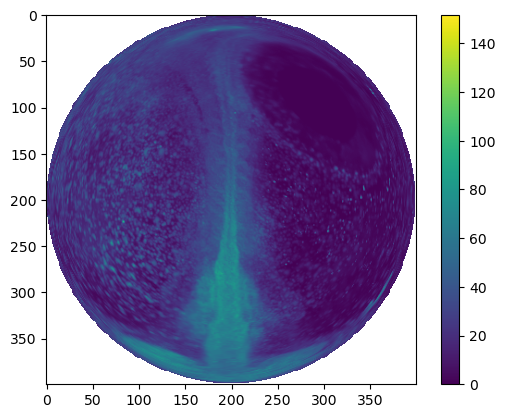

In [14]:
lambert, embedding = lambert_equidistant_projection(f_theta_phi, x_res=400, y_res=400)
plt.imshow(lambert)
plt.colorbar()

It works, but the fish's body isn't centered. What if we wanted to center the fish? Well, I think we have to rotate around the y-axis by some amount.

First lets see how to rotate the fish by looking at its orientation in 3D

In [15]:
# construct affine transform
affine_matrix = (tcreg.package_affine_transformation(np.eye(3), d['center']) @
                    tcreg.package_affine_transformation(rotation_inferred.T, np.zeros(3)) @
                    tcreg.package_affine_transformation(np.eye(3), -d['center']))   
# rotate
im_rotated = ndimage.affine_transform(im, affine_matrix, output_shape=None, order=1,
                                        mode='constant', cval=0.0, prefilter=False) # bilinear interpolation

Text(0, 0.5, 'x')

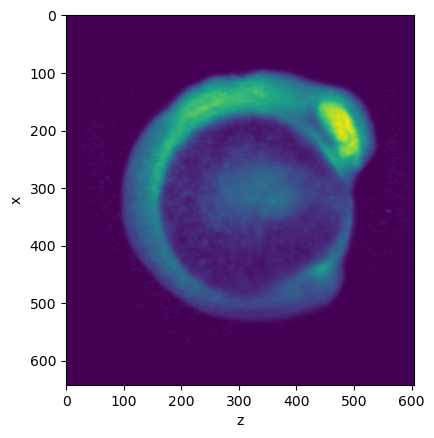

In [19]:
plt.imshow(np.sum(im_rotated, axis=1))
plt.xlabel('z')
plt.ylabel('x')

Note, lambert-azimuthal projection plane is the x-y plane so, from this view it is the plane that is tangent to the left-side of the fish

In [18]:
def rot_y(theta):
    return np.array([
        [np.cos(theta), 0, -np.sin(theta)],
        [0, 1, 0],
        [np.sin(theta), 0, np.cos(theta)]
        ])

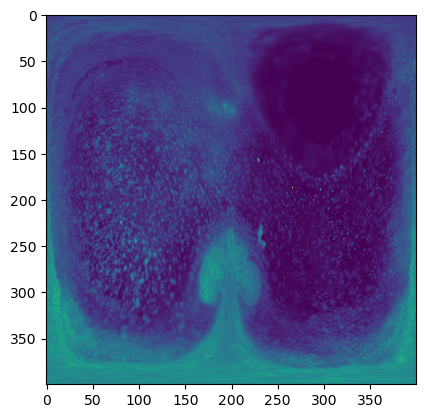

In [23]:
# create the pullback in with the rotation
# based on the above, we rotate by positive degrees if we want the fish head to be more centered
im_vol_rotated = create_rotated_volume(im_vol, (rot_y(np.pi/2) @ rotation_inferred).T, d['center']) 

# change the resolution, use a max projection instead of sum projection for aesthetics
f_rot = np.max(spherical_pullback(im_vol_rotated, d['center'], d['radius'], thickness=64, theta_res=400, phi_res=400), axis=0)

plt.imshow(f_rot)

/tmp/ipykernel_46285/1397629464.py:11: RuntimeWarning: invalid value encountered in arccos
  return 2*np.arccos(R/2) , Theta + np.pi


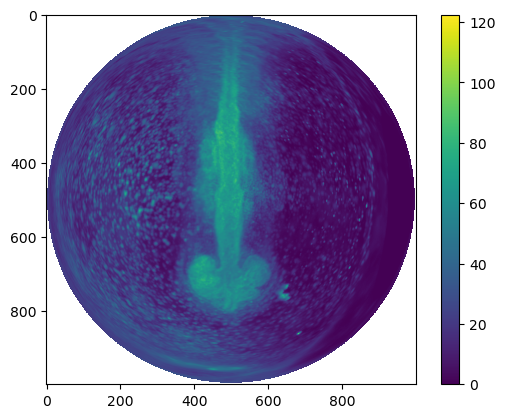

In [25]:
f_theta_phi = create_interpolated_area(f_rot)
lambert, embedding = lambert_equidistant_projection(f_theta_phi, x_res=1000, y_res=1000)
plt.imshow(lambert)
plt.colorbar()

We get the desired result.

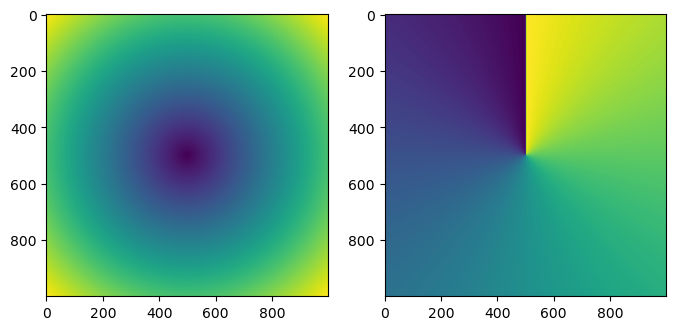

In [29]:
# plot embeddings 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 12))
ax1.imshow(embedding[0])
ax2.imshow(embedding[1])